# <center> Navie Bayes Model

## Load Pacakage.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import plotly.express as px
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
Clean_DF = pd.read_csv('../data/Steam_Clean_Data.csv')
Train_reco = pd.read_csv('../data/Train_reco.csv')
Test_reco = pd.read_csv('../data/Test_reco.csv')

## Transform Recomendation Data.

Use tfidvectorizer to transform text data

In [3]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
DTM_reco=Tfidf_reco.fit_transform(Clean_DF['review'])

Convert tfidvectorizer result to pandas data frame.

In [4]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DTM_DF_reco=pd.DataFrame(DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

## Recommendation Model

### Base Model

Set an instantiate logistic model

In [5]:
## Instantiate
nb_reco=MultinomialNB()

Use trran data to fit the model.

In [6]:
nb_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

MultinomialNB()

Predict the test data

In [7]:
nb_pred_reco=nb_reco.predict(Test_DTM_DF_reco)

Create a confusion matrix


The confusion matrix is:
[[16097 11524]
 [ 3791 52404]]

The accuracy of logistic regression model is:0.82


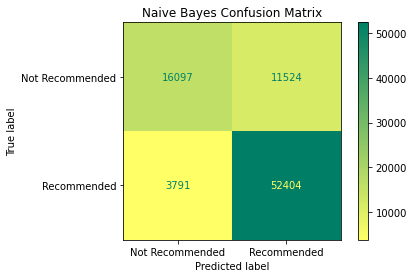

In [8]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], nb_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(nb_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
plt.title("Naive Bayes Confusion Matrix")
plt.savefig('../Visualizations/NB_CM.png')
print("\nThe accuracy of logistic regression model is:%.2f" % accuracy_score(Test_reco['recommendation'], nb_pred_reco))

### Cross Validation

Convert model to integer. 

In [9]:
Label = [1 if Clean_DF.iloc[i,1]=="Recommended" else 0 for i in range(len(Clean_DF))]

Use cross valiadation to generate logistic model.

In [10]:
cv_reco=cross_validate(MultinomialNB(), DTM_DF_reco, Label, cv=6,
                       scoring = ['accuracy','precision','f1'], return_estimator =True)


Print accuracy score

In [11]:
print("The averege accuracy of cross validation is %.2f" % cv_reco['test_accuracy'].mean())
print("The averege precision of cross validation is %.2f" % cv_reco['test_precision'].mean())
print("The averege f1 of cross validation is %.2f" % cv_reco['test_f1'].mean())

The averege accuracy of cross validation is 0.79
The averege precision of cross validation is 0.81
The averege f1 of cross validation is 0.85


## Feature Importance

Create the feature importance for each cross validation.

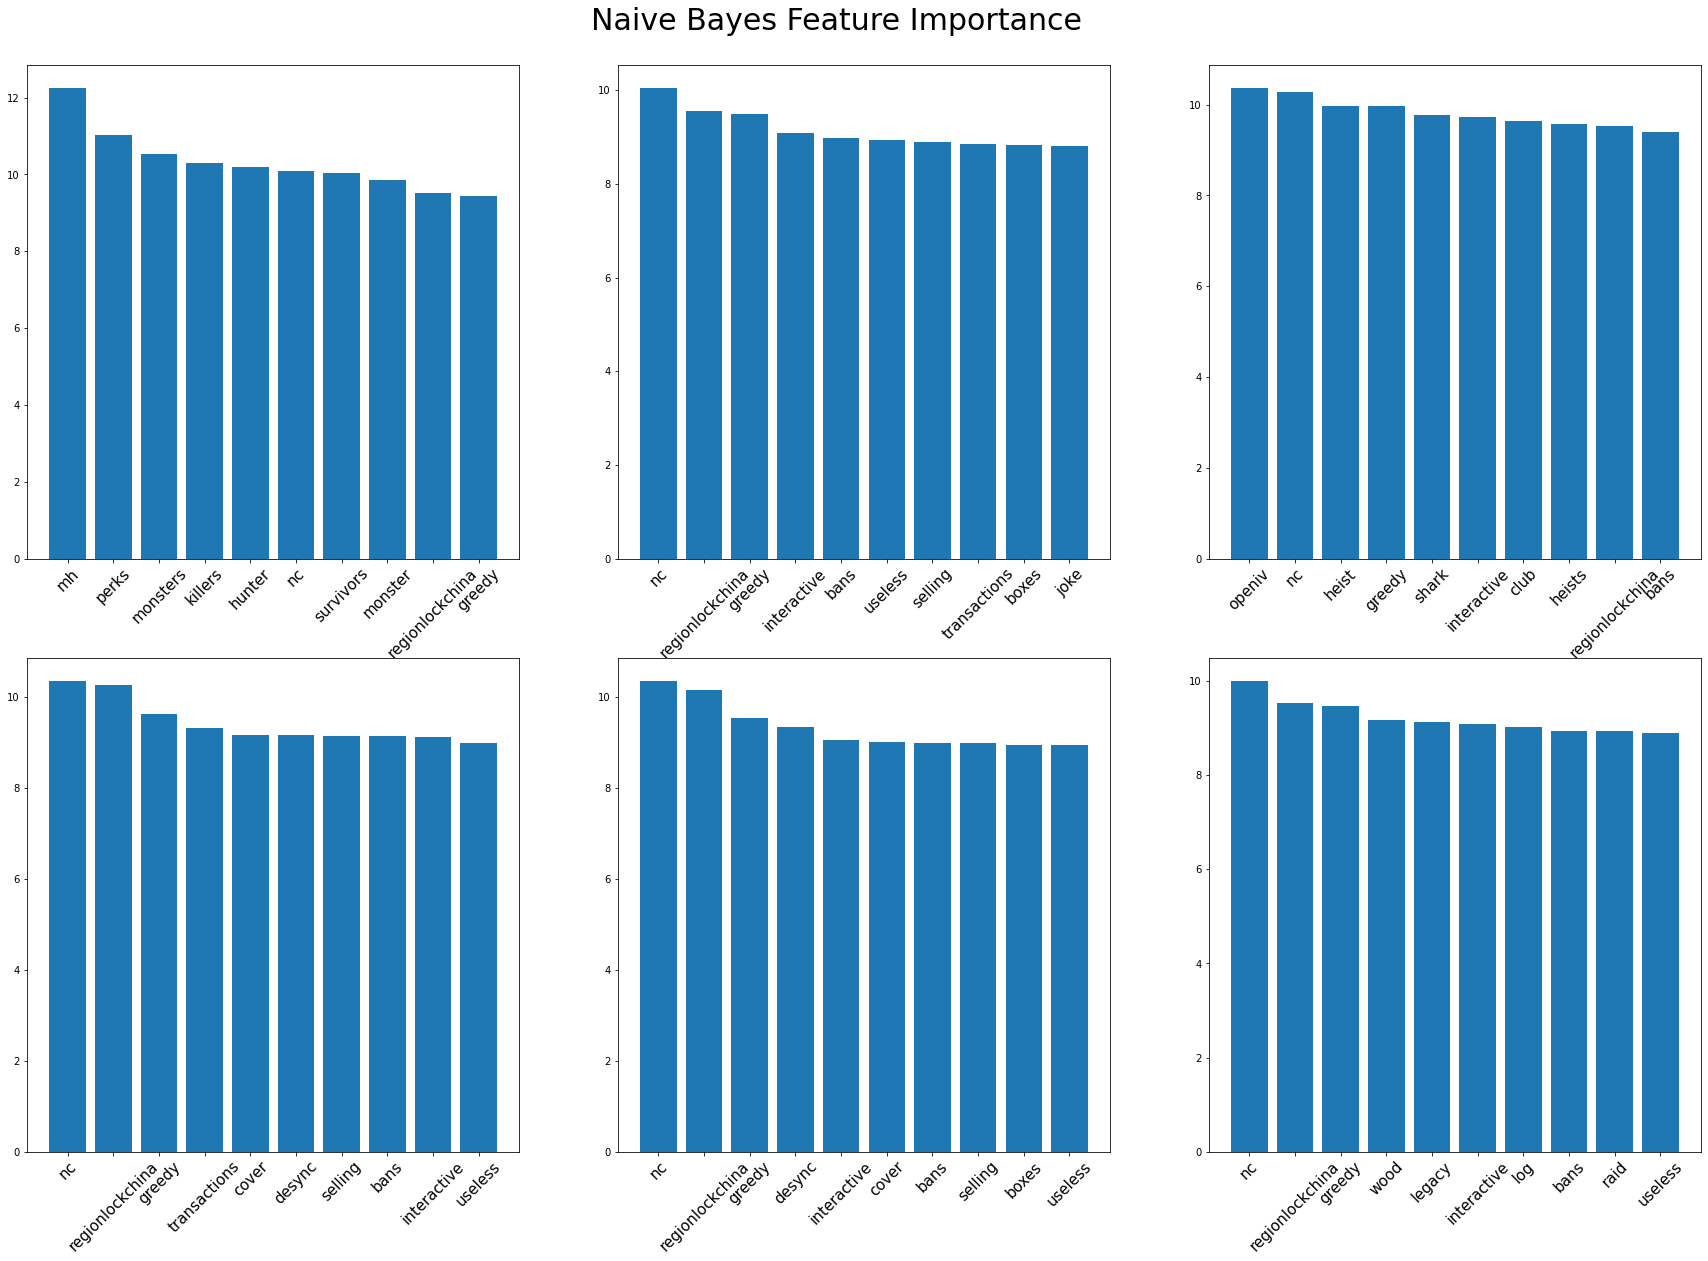

In [12]:
fig=plt.figure(figsize=(30,20))
plt.suptitle("Naive Bayes Feature Importance", fontsize = 30, y = 0.92)
for idx,estimator in enumerate(cv_reco['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.coef_.T*(-1),
                                       index = DTM_DF_reco.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    #print(feature_importances[:10:])
    plt.subplot(231+idx)
    #plot_coefficients(estimator, Train_DTM_DF_reco.columns, 10)
    plt.bar(x = feature_importances.index[:10:], height=feature_importances["importance"][:10:])
    plt.xticks(rotation = 45, fontsize = 15)

plt.savefig("../Visualizations/NB_Imp.png")